# 4 Panel NAM

In [34]:
####################################################
####################################################
####################################################
#
# Libraries
#

import numpy             as np
import datetime          as dt
import matplotlib        as mpl
import matplotlib.pyplot as plt
import ftplib            as ftplib
import urllib.request    as urllibreq
import datetime          as datetime
import os                as os
import platform          as platform
import socket            as socket
import xarray            as xr
import netCDF4           as nc4
import metpy             as metpy
import pathlib           as pathlib
import numpy             as np
import cftime            as cftime
import netCDF4           as nc4
import metpy             as metpy
import cartopy.crs       as ccrs
import cartopy.feature   as cfeature
import pandas            as pd
import pyproj            as pyproj

def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=20,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(np.int(data[mxy[i], mxx[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)

#
####################################################
####################################################
####################################################

## Time Settings

### Setting up Time Intervals

In [35]:
####################################################
####################################################
####################################################
#
# Model Time Intervals
#

time_interval_between_runs            =  6 # hours

time_between_output_steps             =  4 # hours

total_sumulation_time                 = 48 # hours

time_between_boundary_condition_feeds =  3 # hours

#
####################################################
####################################################
####################################################

### Timings for each run

The Realtime WRF is generated every 6 hr at best.  The model takes 3 hr to 

| Model Product Time (UTC) | Wallclock Start Time (UTC) |
|:------------------------:|:--------------------------:|
|        00 UTC            |        03 UTC              |
|        06 UTC            |        09 UTC              |
|        12 UTC            |        15 UTC              |
|        18 UTC            |        21 UTC              |

In [36]:
####################################################
####################################################
####################################################
#
# Identify Specific Run by Wall Clock Window
#

lag_hours = 3

current_datetime = datetime.datetime.utcnow()


current_datetime_lag3 = current_datetime - datetime.timedelta(hours=lag_hours)


if (current_datetime.day == current_datetime_lag3.day):
    if (current_datetime_lag3.hour < 6):
        fx_hour =  0
    elif (current_datetime_lag3.hour < 12):
        fx_hour =  6
    elif (current_datetime_lag3.hour < 18):
        fx_hour = 12
    else:
        fx_hour = 18

    model_start_datetime = datetime.datetime(year  = current_datetime_lag3.year,
                                             month = current_datetime_lag3.month, 
                                             day   = current_datetime_lag3.day, 
                                             hour  = fx_hour)     
else:
    fx_hour = 18
    model_start_datetime = datetime.datetime(year  = current_datetime_lag3.year,
                                             month = current_datetime_lag3.month, 
                                             day   = current_datetime_lag3.day, 
                                             hour  = fx_hour)

    
model_end_datetime        = model_start_datetime + datetime.timedelta(hours=total_sumulation_time)
model_product_dates       = pd.date_range(model_start_datetime, periods=5, freq="12H")
model_product_dates_hours = model_product_dates[1:] - model_product_dates[0]


print("           Current Time ", current_datetime)
print("NAM Forecast Start Time ", model_start_datetime)
print("  NAM Forecast End Time ", model_end_datetime)

print(" ")
print("NAM Forecast Prod Times ", model_product_dates)




#
# Burn Current Time to File in WRF Root Directory
#

model_start_date_YYYYMMDDHH         = model_start_datetime.strftime("%Y%m%d%H")
model_start_date_YYYY_MM_DD_HH      = model_start_datetime.strftime("%Y-%m-%d_%H")
model_start_date_YYYY_MM_DD_HH00UTC = model_start_datetime.strftime("%Y-%m-%d %H00 UTC")


model_thredds_retrieval_date   = model_start_datetime.strftime("%Y%m%d_%H00")

nam_opendap_url = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/NAM/CONUS_40km/conduit/NAM_CONUS_40km_conduit_" + model_thredds_retrieval_date + ".grib2"
                  #https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/NAM/CONUS_40km/conduit/NAM_CONUS_40km_conduit_20220124_0000.grib2
print(" ")

print(nam_opendap_url)

#
####################################################
####################################################
####################################################

           Current Time  2022-02-10 04:18:31.798449
NAM Forecast Start Time  2022-02-10 00:00:00
  NAM Forecast End Time  2022-02-12 00:00:00
 
NAM Forecast Prod Times  DatetimeIndex(['2022-02-10 00:00:00', '2022-02-10 12:00:00',
               '2022-02-11 00:00:00', '2022-02-11 12:00:00',
               '2022-02-12 00:00:00'],
              dtype='datetime64[ns]', freq='12H')
 
https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/NAM/CONUS_40km/conduit/NAM_CONUS_40km_conduit_20220210_0000.grib2


## Crack open GRIB array with Xarray

In [37]:
####################################################
####################################################
####################################################
#
# Crack open the UCAR thredds NOMADS array.
#

nam_model = xr.open_dataset(nam_opendap_url)

nam_model = nam_model.metpy.parse_cf()



data_crs = nam_model.metpy_crs.metpy.cartopy_crs


display(nam_model)


display(data_crs)

eastings2d, northings2d = np.meshgrid(nam_model["x"],nam_model["y"])

pyproj_nam = pyproj.Proj(data_crs)

lon2d, lat2d = pyproj_nam(eastings2d,
                          northings2d,
                          inverse=True)


coriolis = metpy.calc.coriolis_parameter(lat2d*np.pi/180)
coriolis = coriolis.magnitude



#
####################################################
####################################################
####################################################

<xarray.Dataset>
Dimensions:                                                                          (
                                                                                      time: 28,
                                                                                      time_bounds_1: 2,
                                                                                      time2: 52,
                                                                                      time2_bounds_1: 2,
                                                                                      time3: 52,
                                                                                      ...
                                                                                      height_above_ground: 1,
                                                                                      depth_below_surface: 1,
                                                                                      height_above_ground1: 2,
                                                                                      isobaric3: 1,
                                                                                      isobaric2: 2,
                                                                                      hybrid: 2)
Coordinates: (12/35)
    reftime                                                                          datetime64[ns] ...
  * time                                                                             (time) datetime64[ns] ...
  * time2                                                                            (time2) datetime64[ns] ...
  * time3                                                                            (time3) datetime64[ns] ...
  * pressure_difference_layer                                                        (pressure_difference_layer) float32 ...
  * pressure_difference_layer1                                                       (pressure_difference_layer1) float32 ...
    ...                                                                               ...
  * height_above_ground                                                              (height_above_ground) float32 ...
  * depth_below_surface                                                              (depth_below_surface) float32 ...
  * height_above_ground1                                                             (height_above_ground1) float32 ...
  * isobaric3                                                                        (isobaric3) float32 ...
  * isobaric2                                                                        (isobaric2) float32 ...
  * hybrid                                                                           (hybrid) float32 ...
Dimensions without coordinates: time_bounds_1, time2_bounds_1, time3_bounds_1,
                                pressure_difference_layer_bounds_1,
                                pressure_difference_layer1_bounds_1,
                                pressure_difference_layer2_bounds_1,
                                pressure_difference_layer3_bounds_1,
                                pressure_difference_layer4_bounds_1,
                                ...
                                isobaric_layer_bounds_1,
                                height_above_ground_layer1_bounds_1,
                                height_above_ground_layer2_bounds_1,
                                pressure_difference_layer6_bounds_1,
                                depth_below_surface_layer2_bounds_1,
                                sigma_layer_bounds_1
Data variables: (12/198)
    LambertConformal_Projection                                                      int32 ...
    time_bounds                                                                      (time, time_bounds_1) datetime64[ns] ...
    time2_bounds                                                                     (time2, time2_bounds

<Derived Projected CRS: +proj=lcc +ellps=sphere +a=6371229.0 +b=6371229.0  ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (1SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

## Panel Displays

500-hPa Vorticity/Heights

* 500-hPa Absolute Vorticity
* 500-hPa Isobaric Heights

Thickness / MSLP

* Mean Sea Level Pressure
* 1000-500 hPa Thickness

850-hPa Heights and Humidity

* 850-hPA Heights
* 850-hPA Relative Humidity

Precipitation / Vertical Velocity

* 12-hr Precipitation
* 700-hPa Vertical Velocity


## Fetch Data for Pannel Displays

In [38]:
####################################################
####################################################
####################################################
#
# Extract Map Fields
#

k_0500hpa_vort = 2

k_1000hpa_height = 38
k_0850hpa_height = 32
k_0700hpa_height = 26
k_0500hpa_height = 18

# 500-hPa Heights & Vorticity

metpy.calc.coriolis_parameter
vorticity_500       = nam_model[ "Absolute_vorticity_isobaric"][:,k_0500hpa_vort,  :,:]
vorticity_500.values         = (vorticity_500.values - coriolis) * 1e5 
vorticity_500.attrs["units"] = "1e-5 s-1"





heights_500        = nam_model["Geopotential_height_isobaric"][:,k_0500hpa_height,:,:]
heights_500.values = heights_500.values / 10.
heights_500.attrs["units"] = "dam"




heights_500.attrs[  "long_name"] = "500 hPa Geopotential Height"
vorticity_500.attrs["long_name"] = "500 hPa Absolute Vorticity"



# MSLP - Thickness

mslp                = nam_model[ "Pressure_reduced_to_MSL_msl"]
mslp.values         = mslp.values / 100
mslp.attrs["units"] = "hPa"

thickness        = heights_500.copy() 
thickness.values = heights_500.values - nam_model["Geopotential_height_isobaric"][:,k_1000hpa_height,:,:].values/10
thickness.attrs["long_name"] = "1000-500 hPa Thickness"
thickness.attrs["units"]     = "dam"


# 850-hPa Heights & RH

humidity_850    = nam_model[  "Relative_humidity_isobaric"][:,k_0850hpa_height,:,:]
temperature_850 = nam_model[        "Temperature_isobaric"][:,k_0850hpa_height,:,:]
u_850           = nam_model["u-component_of_wind_isobaric"][:,k_0850hpa_height,:,:]
v_850           = nam_model["v-component_of_wind_isobaric"][:,k_0850hpa_height,:,:]

temperature_850.values = temperature_850.values-273.15
temperature_850.attrs["deg C"]     = "dam"




humidity_850.attrs["long_name"] = "850-hPa Relative Humidity"
temperature_850.attrs[ "long_name"] = "850-hPa Isobaric Temperature"

u_850.attrs["long_name"] = "850-hPa Eastward Grid Wind Speed"
v_850.attrs["long_name"] = "850-hPa Northward Grid Wind Speed"



# Precip & 700-hPa VVel



vvel_700   = nam_model["Vertical_velocity_pressure_isobaric"][:,k_0700hpa_height,:,:]

precip = nam_model["Total_precipitation_surface_3_Hour_Accumulation"]




    
#
####################################################
####################################################
####################################################

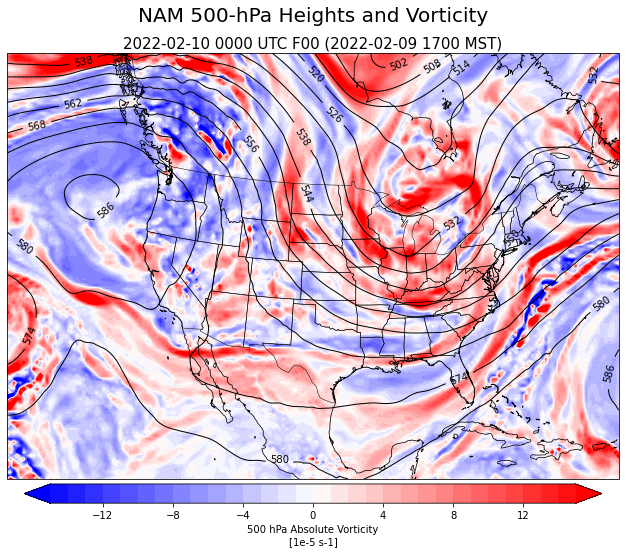

In [39]:
####################################################
####################################################
####################################################
#
# Plot Sample Map for Records
#

start_time = nam_model["reftime"].values
time_dim   = vorticity_500.dims[0]
times_utc  = vorticity_500.coords[time_dim].to_numpy()
fxx        = (times_utc-start_time)/ np.timedelta64(1, 'h')

i = 0

if (i >=0) :

    tz='America/Denver'
    time_utc   = times_utc[i]
    valid_time = pd.to_datetime(start_time).tz_localize(tz="UTC").strftime("%Y-%m-%d %H00 %Z")
    local_time = pd.to_datetime(times_utc[i]).tz_localize(tz="UTC").tz_convert(tz=tz).strftime("%Y-%m-%d %H00 %Z")

    plot_label = "NAM 500-hPa Heights and Vorticity"
    time_label = valid_time + " F" + str(int(fxx[i])).zfill(2)+  " (" + local_time + ")"


    fig = plt.figure(figsize=(11, 8))
    
    plt.suptitle(plot_label,
                     fontsize = 20, 
                     color    = "black")
  
    # add a plot element just one field

                       # nrows, ncols, index [which oddly starts with one (go fig)],
    ax = fig.add_subplot(    1,     1,     1, 
                         projection = data_crs)
    

   

    # of you use the coastlines and add_feature you can see it does 
    #   the full cone and our place on it


    ax.coastlines(resolution = 'auto',
                  linewidths =  0.75)


    ax.add_feature(cfeature.STATES.with_scale('110m'), 
                       linewidths = 0.5,
                       facecolor  = 'none' , 
                       edgecolor  = 'black')


    contourf_levels = np.arange(start = -15,
                                stop  =  16,
                                step  =   1)

    contourf_plot = vorticity_500[0,:,:].plot.contourf(cmap      = plt.cm.bwr,
                                                      extend   = 'both',
                                                      levels    = contourf_levels,
                                                      cbar_kwargs = {"orientation" : "horizontal",
                                                                    "pad":0.01,
                                                                    "shrink":0.75,
                                                                    "aspect":30})    


    contour_levels = np.arange(400,606, 6)

    contour_plot = heights_500[0,:,:].plot.contour(colors     = "black",
                                    linewidths = 1, 
                                    levels     = contour_levels)

    ax.clabel(contour_plot)
    
    
    ax.set_title(time_label,
                        fontsize=15, color="black")


    
    plt.tight_layout()

    plt.show()
#
####################################################
####################################################
####################################################